In [1]:
%load_ext autoreload
import os
import sys

In [2]:
os.environ['TRANSFORMERS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ['HF_DATASETS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ["OPENAI_API_KEY"]= 'xxx'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
sys.path.append('./src-py')

In [3]:
import json
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import re
from collections import Counter

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


%autoreload
import utils
import prompts
import random

from tabulate import tabulate
import tiktoken
from llm_based_evaluation import *

/local/nlp/milad/conda-envs/trl-library/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
from transformers import AutoTokenizer, pipeline

In [5]:
import json
keys = json.load(open('./keys.json'))
for key, val in keys.items():
    os.environ[key] = val

In [6]:
from huggingface_hub import login

login(os.environ['hf_token'])

In [7]:
output_dir = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/'
models_folder = "/mnt/swordfish-pool2/milad/communicating-science-to-the-public/models/"

In [8]:
gpt_tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

In [9]:
ds_path = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500'

### Evaluating the Researcher

#### Using DeepSeek

In [28]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_quesions/'), ds_path + '/baseline_qwen_gen_conv_fixed_quesions'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv_fixed_quesions/'),ds_path +  '/ft_qwen_gen_conv_fixed_quesions/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv_fixed_quesions/'), ds_path + '/baseline_llama3_gen_conv_fixed_quesions'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv_fixed_quesions/'),ds_path +  '/ft_llama3_gen_conv_fixed_quesions/'],
}

In [13]:
#print(generated_convs['ft-qwen-on-deepseek'][0]['fixed_journalist_conv'][0])

In [ ]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]
for p in prompts_to_eval:
    p['inputs']['Conversation'] = 'fixed_journalist_conv'

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [37:52<00:00,  4.55s/it]


Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

  2%|█▌                                                                              | 10/500 [00:41<33:16,  4.08s/it]

In [41]:
llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/baseline_qwen_gen_conv_fixed_quesions/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/ft_qwen_gen_conv_fixed_quesions//ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/baseline_llama3_gen_conv_fixed_quesions/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/ft_llama3_gen_conv_fixed_quesions//ds_eval/deepseek-ai from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          3.75                      2.97                    2.91   

### Evaluating the Journalist

#### Basic Eval

In [24]:
generated_convs = {
    'qwen-baseline':datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_researcher'),
    'ft-qwen-on-deepseek' :datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv_fixed_researcher'),
    'llama-baseline':datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv_fixed_researcher'),
    'ft-llama-on-deepseek' :datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv_fixed_researcher')
}

In [25]:
print("{}\n---\n\n".format(generated_convs['ft-llama-on-deepseek']['paper_title'][4]),"\n\n==\n\n".join([x['content'] for x in generated_convs['ft-llama-on-deepseek']['generated_conversation'][4] if x['role'] == 'assistant']))

Two-way traffic for cell migration
---

 Thank you for providing the abstract of the scientific paper. It seems that the study explores the behavior of cells in confined environments and their interactions with their microenvironment. The researchers observed that cells in a stripe-shaped pattern exhibited a shear flow, which was absent in a larger stripe. They also found that the tilt angle of the cells varied with the stripe width.

==

That’s fascinating! So, the study not only describes the behavior of cells in confined environments but also provides a theoretical framework to understand these behaviors. The hydrodynamic active gel theory seems to be a key tool in explaining the observed phenomena. Could you explain how this theory helps in understanding the behavior of the cells in the stripe-shaped pattern?

Also, you mentioned that the tilt angle of the cells varies with the width of the stripe. How does this variation affect the overall dynamics of the cell migration? Does this

In [26]:
print('Results on 500 sample')
all_synth_conversations = utils.evalaute_convs(generated_convs)

Results on 500 sample
Prompt                  Rouge-1    Rouge-L    BERT-f1
--------------------  ---------  ---------  ---------
qwen-baseline             0.262      0.126      0.768
ft-qwen-on-deepseek       0.368      0.146      0.825
llama-baseline            0.331      0.143      0.816
ft-llama-on-deepseek      0.377      0.155      0.824


In [71]:
print('Results on 500 sample')
all_synth_conversations = utils.evalaute_convs(generated_convs)

Results on 500 sample


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prompt                  Rouge-1    Rouge-L    BERT-f1
--------------------  ---------  ---------  ---------
qwen-baseline             0.262      0.126      0.768
ft-qwen-on-deepseek       0.252      0.123      0.768
llama-baseline            0.331      0.143      0.816
ft-llama-on-deepseek      0.377      0.155      0.824


#### LLM-based Eval

In [27]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_researcher'), ds_path + '/baseline_qwen_gen_conv_fixed_researcher'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv_fixed_researcher'),ds_path +  '/ft_qwen_gen_conv_fixed_researcher'],
    #'qwen-baseline-b':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_researcher'), ds_path + '/baseline_qwen_gen_conv_w_qwen_base_researcher'],
    #'ft-qwen-on-deepseek-b' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv_fixed_researcher'),ds_path +  '/ft_qwen_gen_conv_w_qwen_base_researcher'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv_fixed_researcher'), ds_path + '/baseline_llama3_gen_conv_fixed_researcher'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv_fixed_researcher'),ds_path +  '/ft_llama3_gen_conv_fixed_researcher'],
}

In [28]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/baseline_qwen_gen_conv_fixed_researcher/ds_eval/deepseek-ai from already saved file


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [39:52<00:00,  4.78s/it]


Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/baseline_llama3_gen_conv_fixed_researcher/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/ft_llama3_gen_conv_fixed_researcher/ds_eval/deepseek-ai from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          2.26                      1.25                    1.13   1.55
ft-qwen-on-deepseek                    4.09                      2.05                    1.82   2.65
llama-baseline                         4.02                      1.99                    1.45   2.49
ft-llama-on-deepseek                   4.08                      2.02                    1.63   2.58


Performing statistical analysis on the ta scores

In [32]:
ft_scores = [x['score'] for x in llm_eval_results['ft-llama-on-deepseek']['clarity_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['llama-baseline']['clarity_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)
print('=====')
ft_scores = [x['score'] for x in llm_eval_results['ft-llama-on-deepseek']['scientific_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['llama-baseline']['scientific_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)
print('=====')
ft_scores = [x['score'] for x in llm_eval_results['ft-llama-on-deepseek']['societal_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['llama-baseline']['societal_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)

Paired T-test Results:
T-statistic: 21807.0
P-value: 0.2183658922348688

Interpretation:
The p-value (0.2184) is greater than the significance level (0.05).
Conclusion: There is no statistically significant difference between the two systems.
=====
Paired T-test Results:
T-statistic: 24224.0
P-value: 0.595994397526662

Interpretation:
The p-value (0.5960) is greater than the significance level (0.05).
Conclusion: There is no statistically significant difference between the two systems.
=====
Paired T-test Results:
T-statistic: 10558.0
P-value: 2.636493206744125e-06

Interpretation:
The p-value (0.0000) is less than the significance level (0.05).
Conclusion: There is a statistically significant difference between the two systems.


In [33]:
ft_scores = [x['score'] for x in llm_eval_results['ft-qwen-on-deepseek']['clarity_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['qwen-baseline']['clarity_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)
print('=====')
ft_scores = [x['score'] for x in llm_eval_results['ft-qwen-on-deepseek']['scientific_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['qwen-baseline']['scientific_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)
print('=====')
ft_scores = [x['score'] for x in llm_eval_results['ft-qwen-on-deepseek']['societal_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['qwen-baseline']['societal_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)

Paired T-test Results:
T-statistic: 4228.5
P-value: 1.0357037257464e-62

Interpretation:
The p-value (0.0000) is less than the significance level (0.05).
Conclusion: There is a statistically significant difference between the two systems.
=====
Paired T-test Results:
T-statistic: 5775.0
P-value: 2.559163849141833e-40

Interpretation:
The p-value (0.0000) is less than the significance level (0.05).
Conclusion: There is a statistically significant difference between the two systems.
=====
Paired T-test Results:
T-statistic: 3356.0
P-value: 2.6400341736914437e-49

Interpretation:
The p-value (0.0000) is less than the significance level (0.05).
Conclusion: There is a statistically significant difference between the two systems.


-------

### Analysis of the automatic evalaution

In [34]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_researcher'), ds_path + '/baseline_qwen_gen_conv_fixed_researcher'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv_fixed_researcher'),ds_path +  '/ft_qwen_gen_conv_fixed_fixed_researcher'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv_fixed_researcher'), ds_path + '/baseline_llama3_gen_conv_fixed_researcher'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv_fixed_researcher'),ds_path +  '/ft_llama3_gen_conv_fixed_researcher'],
}

In [97]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/baseline_qwen_gen_conv_fixed_researcher/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/ft_qwen_gen_conv_fixed_fixed_researcher/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/baseline_llama3_gen_conv_fixed_researcher/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/ft_llama3_gen_conv_fixed_researcher/ds_eval/deepseek-ai from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          2.26                      1.25               

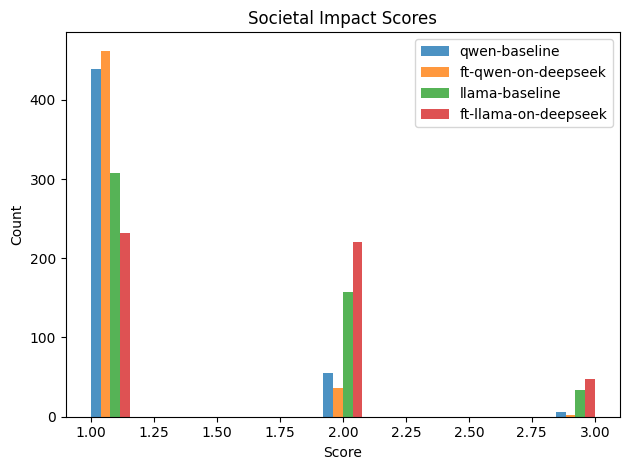

In [102]:
utils.histogram_of_scores(llm_eval_results, 'societal_eval_prompt_scoring_parsed', 'Societal Impact Scores')

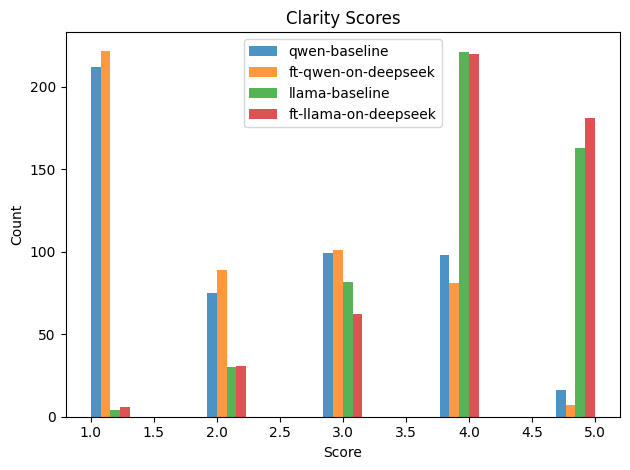

In [103]:
utils.histogram_of_scores(llm_eval_results, 'clarity_eval_prompt_scoring_parsed', 'Clarity Scores')

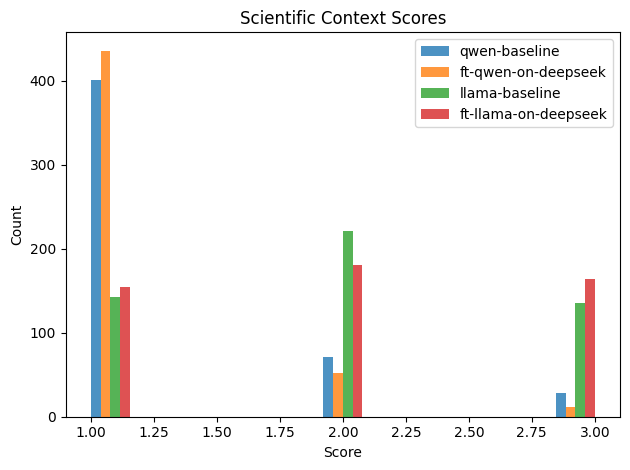

In [104]:
utils.histogram_of_scores(llm_eval_results, 'scientific_eval_prompt_scoring_parsed', 'Scientific Context Scores')